In [294]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import shap

In [295]:
# Load Apple stock data using yfinance
data = yf.download('INFY.NS', start='2023-01-01', end=datetime.today().strftime('%Y-%m-%d'))
data.reset_index(inplace=True)
data['Target'] = data['Close']

[*********************100%***********************]  1 of 1 completed


In [296]:
# Add additional features: RSI, SMA, and support/resistance levels
# Calculate RSI
window_length = 14
close = data['Close']
delta = close.diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi

In [297]:
# Calculate SMA (Simple Moving Average)
data['SMA_20'] = data['Close'].rolling(window=20).mean()

In [298]:
# Define support and resistance (for simplicity, use rolling min and max)
data['Support'] = data['Close'].rolling(window=20).min()
data['Resistance'] = data['Close'].rolling(window=20).max()

In [299]:
# Drop NaN values resulting from rolling calculations
data.dropna(inplace=True)

In [300]:
# Define features and target
features = data[['Open', 'Volume', 'RSI', 'SMA_20', 'Support', 'Resistance']].values
target = data['Target'].values

In [301]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features, target, data['Date'], test_size=0.2, random_state=42)


In [302]:
# Best parameters and model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
model = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [303]:
#Train the catBoost model
model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [304]:
# Make predictions
y_pred = model.predict(X_test)

In [305]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 257.9652351175145
R-squared: 0.9956450656205037


In [306]:
# Define Buy/Sell/Hold indicators
threshold = 0.02  # 2% threshold for Buy/Sell
indicators = []
for actual, predicted in zip(y_test, y_pred):
    if predicted > actual * (1 + threshold):
        indicators.append('BUY')
    elif predicted < actual * (1 - threshold):
        indicators.append('SELL')
    else:
        indicators.append('HOLD')

In [307]:

# Create a DataFrame to show actual prices, predicted prices, and indicators
results = pd.DataFrame({
    'Date': date_test.values,
    'Actual Price': y_test,
    'Predicted Price': y_pred,
    'Indicator': indicators
})

In [308]:
# Print the results
print(results.head())

        Date  Actual Price  Predicted Price Indicator
0 2024-10-11   1935.099976      1925.796581      HOLD
1 2025-01-02   1957.849976      1904.179416      SELL
2 2023-10-25   1370.050049      1401.040965       BUY
3 2024-11-22   1902.250000      1881.841754      HOLD
4 2024-04-18   1419.250000      1433.695803      HOLD


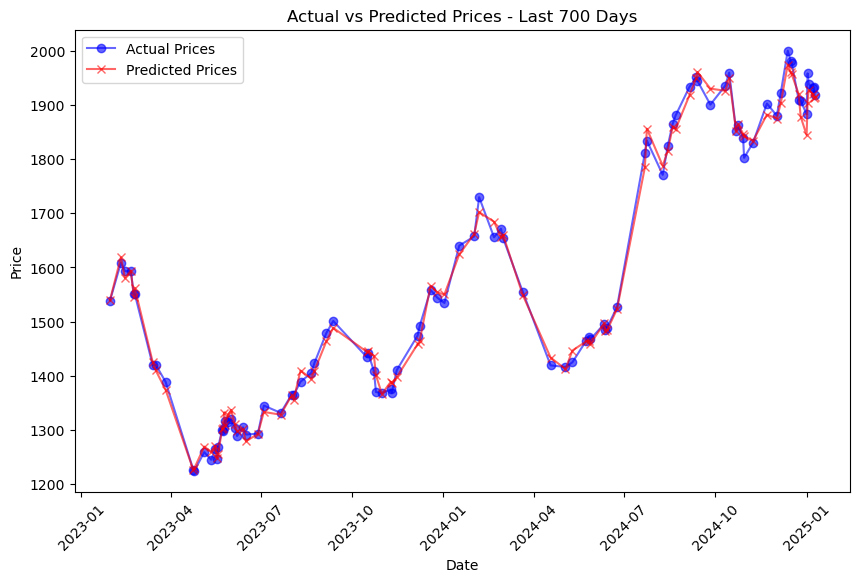

In [309]:
# Visualize predictions vs actual values for the last 15 days
last_15_days = results.sort_values(by='Date').tail(1000)
plt.figure(figsize=(10, 6))
plt.plot(last_15_days['Date'], last_15_days['Actual Price'], label="Actual Prices", color="blue", alpha=0.6, marker='o')
plt.plot(last_15_days['Date'], last_15_days['Predicted Price'], label="Predicted Prices", color="red", alpha=0.6, marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices - Last 700 Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

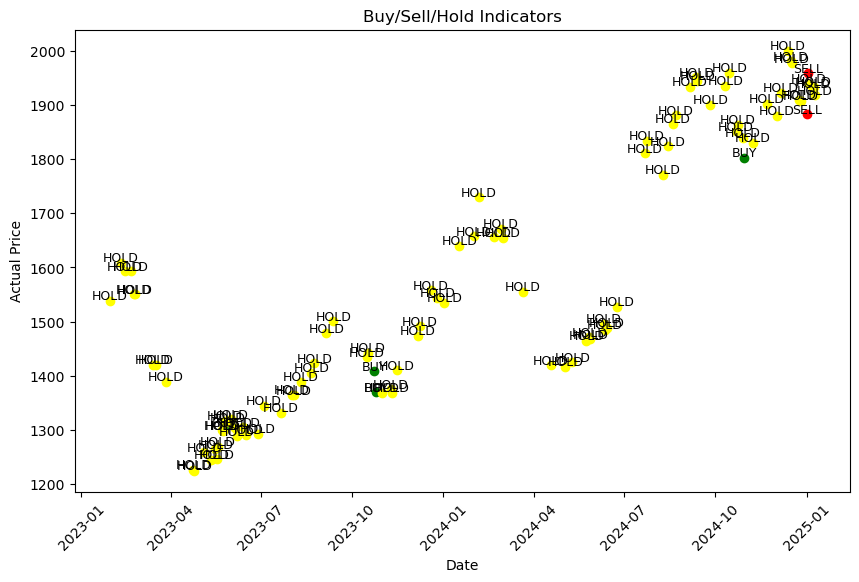

In [310]:
# Visualize Buy/Sell/Hold Indicators
plt.figure(figsize=(10, 6))
for i, (date, actual, indicator) in enumerate(zip(results['Date'], results['Actual Price'], results['Indicator'])):
    color = 'green' if indicator == 'BUY' else 'red' if indicator == 'SELL' else 'yellow'
    plt.scatter(date, actual, color=color)
    plt.text(date, actual + 2, indicator, fontsize=9, ha='center')  # Adding labels above points

plt.title("Buy/Sell/Hold Indicators")
plt.xlabel("Date")
plt.ylabel("Actual Price")
plt.xticks(rotation=45)
plt.show()

In [311]:
# Predict for future dates using the last available Open and Volume data
last_open = data['Open'].iloc[-1]
last_volume = data['Volume'].iloc[-1]
last_rsi = data['RSI'].iloc[-1]
last_sma = data['SMA_20'].iloc[-1]
last_support = data['Support'].iloc[-1]
last_resistance = data['Resistance'].iloc[-1]

future_data = pd.DataFrame({
    'Date': [datetime.today() + timedelta(days=i) for i in range(1, 11)],  # Future dates from today
    'Open': [last_open] * 10,  # Use the last known Open price
    'Volume': [last_volume] * 10,  # Use the last known Volume
    'RSI': [last_rsi] * 10,  # Use the last known RSI
    'SMA_20': [last_sma] * 10,  # Use the last known SMA
    'Support': [last_support] * 10,  # Use the last known Support
    'Resistance': [last_resistance] * 10  # Use the last known Resistance
})

In [312]:
# Make future predictions
future_predictions = model.predict(future_data[['Open', 'Volume', 'RSI', 'SMA_20', 'Support', 'Resistance']].values)

In [313]:
# Define future Buy/Sell/Hold indicators
future_indicators = []
stop_losses = []  # Add stop-loss levels
for open_price, predicted in zip(future_data['Open'].to_numpy(), future_predictions):
    open_price = open_price.item()  # Ensure open_price is a scalar
    stop_loss = open_price * 0.98  # Set stop-loss as 2% below the open price
    stop_losses.append(stop_loss)
    if predicted > open_price * (1 + threshold):
        future_indicators.append('BUY')
    elif predicted < open_price * (1 - threshold):
        future_indicators.append('SELL')
    else:
        future_indicators.append('HOLD')

In [314]:
# Display future predictions with indicators and stop-loss
future_results = pd.DataFrame({
    'Date': future_data['Date'],
    'Future Open': future_data['Open'],
    'Future Volume': future_data['Volume'],
    'Predicted Close Price': future_predictions,
    'Stop Loss': stop_losses,
    'Indicator': future_indicators
})

print("Future Predictions:")
print(future_results)

Future Predictions:
                        Date  \
0 2025-01-17 01:15:27.274721   
1 2025-01-18 01:15:27.274721   
2 2025-01-19 01:15:27.274721   
3 2025-01-20 01:15:27.274721   
4 2025-01-21 01:15:27.274721   
5 2025-01-22 01:15:27.274721   
6 2025-01-23 01:15:27.274721   
7 2025-01-24 01:15:27.274721   
8 2025-01-25 01:15:27.274721   
9 2025-01-26 01:15:27.274721   

                                         Future Open  \
0  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
1  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
2  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
3  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
4  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
5  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
6  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
7  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
8  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   
9  Ticker
INFY.NS    1947.0
Name: 501, dtype: flo...   

          

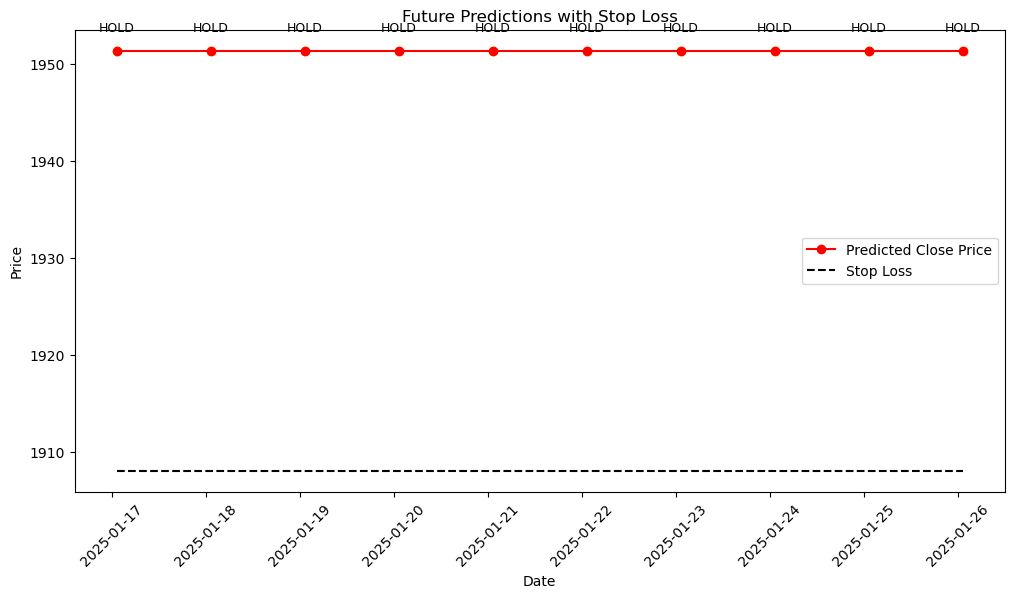

In [316]:
# Visualize future Buy/Sell/Hold Indicators with Stop Loss
plt.figure(figsize=(12, 6))
plt.plot(future_results['Date'], future_results['Predicted Close Price'], label="Predicted Close Price", color="red", marker='o')
plt.plot(future_results['Date'], future_results['Stop Loss'], label="Stop Loss", color="black", linestyle='dashed')
for date, predicted, stop_loss, indicator in zip(future_results['Date'], future_results['Predicted Close Price'], future_results['Stop Loss'], future_results['Indicator']):
    color = 'green' if indicator == 'BUY' else 'red' if indicator == 'SELL' else 'yellow'
    plt.scatter(date, predicted, color=color)
    plt.text(date, predicted + 2, indicator, fontsize=9, ha='center')

plt.title("Future Predictions with Stop Loss")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [317]:
feature_importances = model.feature_importances_
feature_names = ['Open', 'Volume', 'RSI', 'SMA_20', 'Support', 'Resistance']
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(importance_df)


      Feature  Importance
0        Open   31.764905
4     Support   19.176384
3      SMA_20   18.116176
5  Resistance   17.380467
2         RSI   11.139784
1      Volume    2.422284


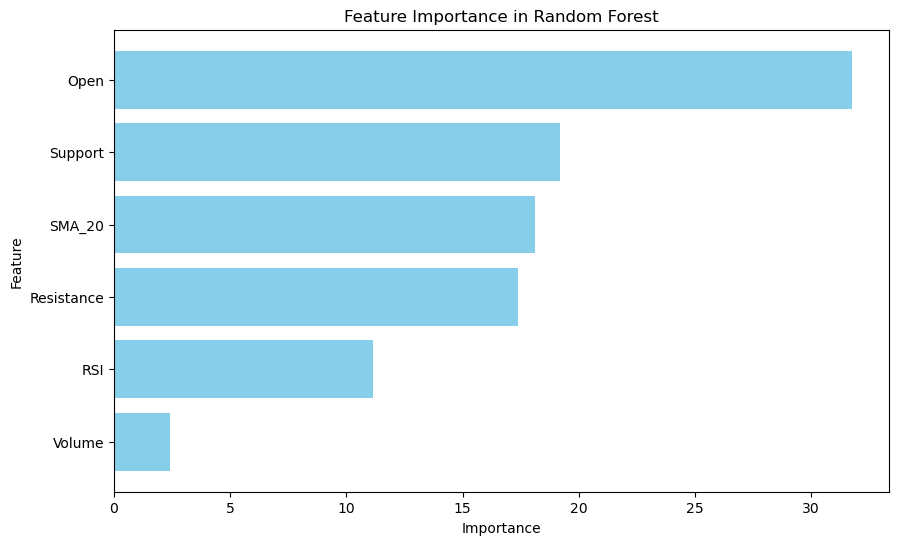

In [318]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()
